# **Livrable 2 – Modélisation du Time-Dependent Vehicle Routing Problem (TDVRP)** 
### Projet ADEME – Mobilité Multimodale Intelligente  
**Équipe :** CesiCDP – Groupe de Louka, Evan, Mael, Hugo  
**Date :** Octobre 2025  
---



## 1. Introduction et Contexte

Depuis les années 90, il y a eu une prise de conscience mondiale de la nécessité de réduire la consommation d'énergie et les émissions de gaz à effet de serre. Les premiers engagements sont apparus lors du **Protocole de Kyoto (1997)**, suivi d'autres plus ambitieux comme la **division par 4 des émissions d’ici 2050 en France**.  

Dans ce contexte, **l’ADEME (Agence de l’Environnement et de la Maîtrise de l’Énergie)** a lancé un appel à manifestation d’intérêt pour promouvoir des **solutions de mobilité innovantes** et plus écologiques.  

Notre équipe **CesiCDP** s’inscrit dans cette démarche à travers une étude sur la **mobilité multimodale intelligente**. Nous avons choisi de nous concentrer sur l’**optimisation des tournées de livraison**, un enjeu central de la logistique moderne.  

Nous modélisons ici un problème de **gestion de tournées (Vehicle Routing Problem - VRP)** en intégrant une **contrainte de trafic dynamique**, pour mieux représenter les conditions de circulation réelles. Notre flotte de véhicules est **thermique et homogène**, ce qui accentue l’importance de la réduction du temps de trajet et de la consommation de carburant.


## 2. Choix de la Méthode : Le Recuit Simulé (SA)

Pour résoudre ce problème, nous avons choisi une **métaheuristique : l'Algorithme du Recuit Simulé (Simulated Annealing)**.

Ce choix est motivé par la nature du problème :

1.  **Problème NP-difficile :** Le VRP (et à plus forte raison le TDVRP) est un problème "NP-difficile". Il est **informatiquement impossible de trouver la solution optimale garantie** en un temps raisonnable pour une instance de 200 clients. Nous devons donc nous tourner vers des méthodes d'approximation.
2.  **Évitement des Minimums Locaux :** Une heuristique simple (comme une "descente") améliorerait la solution en n'acceptant que les "voisins" (solutions légèrement modifiées) qui sont meilleurs. Elle se retrouverait cependant très vite "coincée" dans un **minimum local** : une solution qui *semble* bonne, mais qui n'est pas la meilleure.
3.  **Force du Recuit Simulé :** Le SA surmonte ce problème. Grâce à sa composante aléatoire (`random.random() < math.exp(-delta_cout / temp)`), il s'autorise à **accepter temporairement de moins bonnes solutions**. Cette capacité à "dégrader" la solution lui permet de s'échapper des minimums locaux et d'explorer plus largement l'espace de recherche.
4.  **Flexibilité face aux Contraintes :** Notre contrainte de trafic (`GestionnaireTempsTrajet`) rend le coût d'une tournée non linéaire et complexe. Le Recuit Simulé est parfaitement adapté à cela : il n'a pas besoin de "comprendre" la contrainte, il lui suffit d'évaluer le coût final de la solution (via `calculer_cout`) pour prendre ses décisions.

## 3. Modélisation : Objectif et Contraintes

Notre modèle, implémenté dans le code, vise à optimiser les tournées en respectant un ensemble de règles strictes.

### Objectif : Minimiser le "Makespan"

L'objectif de notre algorithme n'est pas de minimiser la distance totale, mais de **minimiser l'heure de retour du dernier véhicule au dépôt** (`self.cout = temps_retour_max`). C'est un objectif logistique classique (minimisation du "makespan"), qui vise à ce que tous les chauffeurs terminent leur journée le plus tôt possible.

### Contraintes de Validité

Pour qu'une solution soit considérée comme "valide" (coût fini), elle doit respecter deux contraintes majeures :

1.  **Contrainte de Capacité :** La somme des demandes de tous les clients d'une même tournée ne doit jamais dépasser la capacité maximale du véhicule (`if charge_actuelle > instance.capacite_vehicule:`).
2.  **Contrainte de Complétude :** *Tous* les clients listés dans l'instance doivent être servis, et ce, une seule fois (`if len(clients_servis) != len(instance.ids_clients):`).

Si l'une de ces contraintes est violée, la solution est jugée **invalide** et se voit assigner un **coût infini** (`float('inf')`).

### Contrainte Principale : Le Trafic (TDVRP)

La complexité de notre modèle vient de la gestion du temps. Le temps de trajet entre deux points n'est pas constant : il dépend de l'heure de départ (`temps_actuel`) et d'un multiplicateur de trafic. Le temps s'accumule donc de manière dynamique tout au long de la tournée.

- De 0h00 (0 min) à 7h59 : le trafic est normal (multiplicateur x1.0).

- De 8h00 (480 min) à 9h59 : c'est la pointe du matin (multiplicateur x1.8). Les trajets prennent 80% plus de temps.

- De 10h00 (600 min) à 15h59 : c'est creux (multiplicateur x1.2).

- De 16h00 (960 min) à 17h59 : c'est la pointe du soir (multiplicateur x2.0). Les trajets prennent le double du temps.

- À partir de 18h00 (1080 min) : le trafic redevient normal (x1.0).

In [1]:
import openpyxl             # permet de lire les fichiers excel ==> utilisé charger_donnees_excel pour ouvrir le fichier donnees_vrp.xlsx
import numpy as np          # pour les calculs mathématiques, surtout avec des matrices. C'est beaucoup plus rapide que les listes Python classiques pour ce genre de tâche.==> utilisé dans InstanceVRP pour calculer la distance euclidienne (le théorème de Pythagore)
import math                 # Fournit des fonctions mathématiques de base (sin, cos, exp, etc.). ==> utilisé dans resoudre_par_recuit_simule C'est le cœur du Recuit Simulé ! On l'utilise pour le calcul de "probabilité d'accepter une mauvaise solution".
import random               # C'est le module pour tout ce qui est aléatoire. Choisir au hasard, mélanger une liste, etc. ==> utilisé dans creer_solution_initiale (pour mélanger les clients. ) & creer_voisin_aleatoire (pour choisir entre "Relocate" et "Swap" et aussi pour choisir des clients au hasard.) & resoudre_par_recuit_simule (pour décider si on accepte ou non une moins bonne solution.)
import copy                 # Permet de faire de vraies copies (des doublons) des listes ou objets. C'est un point très important. ==> utilisé dans creer_voisin_aleatoire & resoudre_par_recuit_simule
import time                 # Permet de mesurer le temps. ==> utilisé dans resoudre_par_recuit_simule 
from pathlib import Path    # outil moderne pour gérer les chemins de fichiers (les "path") d'une manière qui marche sur tous les ordinateurs (Windows, Mac...).
import vrplib               # <-- NOUVEAU: Pour la validation scientifique

# --- 1. Gestionnaire de Temps ---

class GestionnaireTempsTrajet:
    """
    Calcule le temps de trajet entre deux points en fonction
    de l'heure de départ et des multiplicateurs de trafic.
    """
    def __init__(self, matrice_distances_base, tranches_horaires_minutes, multiplicateurs):
        self.temps_trajet_base = matrice_distances_base
        self.tranches_horaires = tranches_horaires_minutes
        self.multiplicateurs = multiplicateurs

    def calculer_temps_trajet_et_arrivee(self, id_noeud_depart, id_noeud_arrivee, temps_depart_minutes):
        """
        Calcule le temps de trajet réel et l'heure d'arrivée.
        """
        # Trouver le bon multiplicateur de trafic
        multiplicateur_actuel = 1.0
        for i in range(len(self.tranches_horaires)):
            if temps_depart_minutes >= self.tranches_horaires[i]:
                multiplicateur_actuel = self.multiplicateurs[i]
            else:
                break
                
        temps_base = self.temps_trajet_base[id_noeud_depart, id_noeud_arrivee]
        temps_trajet_reel = temps_base * multiplicateur_actuel
        
        temps_arrivee_minutes = temps_depart_minutes + temps_trajet_reel
        
        return temps_trajet_reel, temps_arrivee_minutes

# --- 2. Classes de Données (Instance et Solution) ---

class InstanceVRP:
    """
    Stocke toutes les données du problème lues depuis l'Excel.
    (Capacité, demandes, coordonnées, etc.)
    """
    # Le paramètre 'matrice_explicite' a été supprimé
    def __init__(self, config, coords, demandes, noms):
        self.capacite_vehicule = config['CapaciteVehicule']
        self.nb_vehicules = config['NombreVehicules']
        self.id_depot = config['DepotID']
        
        self.coords_noeuds = coords
        self.demandes_clients = demandes
        self.noms_noeuds = noms
        
        self.ids_noeuds = sorted(list(self.coords_noeuds.keys()))
        self.nb_noeuds = len(self.ids_noeuds)
        
        self.ids_clients = [idx for idx in self.ids_noeuds if idx != self.id_depot]
        
        # Convertisseur entre l'ID (ex: 80) et l'index (ex: 3)
        self.id_vers_idx = {id_noeud: i for i, id_noeud in enumerate(self.ids_noeuds)}
        
        # On calcule toujours la matrice (Euclidienne) depuis l'Excel
        self.matrice_distances = np.zeros((self.nb_noeuds, self.nb_noeuds))
        for id1 in self.ids_noeuds:
            for id2 in self.ids_noeuds:
                if id1 == id2:
                    continue
                
                idx1 = self.id_vers_idx[id1]
                idx2 = self.id_vers_idx[id2]
                
                p1 = self.coords_noeuds[id1]
                p2 = self.coords_noeuds[id2]
                dist = np.linalg.norm(np.array(p1) - np.array(p2))
                
                self.matrice_distances[idx1, idx2] = dist

class Solution:
    """
    Représente une solution : une liste de tournées et son coût total.
    """
    def __init__(self, tournees, cout=float('inf')):
        self.tournees = tournees
        self.cout = cout 
        self.temps_calcul_interne = 0

    def calculer_cout(self, instance, gestionnaire_temps):
        """
        Calcule le coût (date de retour max) de la solution en tenant compte
        du trafic dynamique, de la capacité, et de la complétude.
        
        NOTE : Ceci est la version LENTE qui recalcule TOUT.
        Elle est utilisée pour la solution initiale mais pas dans l'optimisation.
        """
        temps_retour_max = 0
        solution_valide = True
        clients_servis = set()
        
        for tournee in self.tournees:
            temps_actuel = 0.0 # Départ du dépôt à t=0
            charge_actuelle = 0
            id_noeud_actuel = instance.id_depot
            
            tournee_valide = True # Vérifier chaque tournée
            
            for id_noeud_suivant in tournee[1:]: 
                
                # Ajouter le client au set (s'il n'est pas le dépôt)
                if id_noeud_suivant != instance.id_depot:
                    clients_servis.add(id_noeud_suivant)
                
                # 1. Vérifier la capacité
                charge_actuelle += instance.demandes_clients.get(id_noeud_suivant, 0)
                if charge_actuelle > instance.capacite_vehicule:
                    solution_valide = False # La solution GLOBALE est invalide
                    tournee_valide = False # Cette TOURNEE est invalide
                    break 
                
                # 2. Calculer le temps (Dynamique)
                idx_noeud_actuel = instance.id_vers_idx[id_noeud_actuel]
                idx_noeud_suivant = instance.id_vers_idx[id_noeud_suivant]
                
                temps_trajet, temps_arrivee = gestionnaire_temps.calculer_temps_trajet_et_arrivee(
                    idx_noeud_actuel, idx_noeud_suivant, temps_actuel
                )
                
                temps_actuel = temps_arrivee
                id_noeud_actuel = id_noeud_suivant
            
            # Mettre à jour le temps de retour (uniquement pour les tournées valides et non-vides)
            if tournee_valide and len(tournee) > 2 and temps_actuel > temps_retour_max:
                temps_retour_max = temps_actuel
        
        # 3. Vérifier que TOUS les clients sont servis
        # On fait cette vérification APRES avoir parcouru TOUTES les tournées
        if len(clients_servis) != len(instance.ids_clients):
            solution_valide = False
        
        if not solution_valide:
            self.cout = float('inf') 
            return self.cout
        
        self.cout = temps_retour_max
        return self.cout

# --- 3. Opérateurs de Voisinage ---

def creer_voisin_aleatoire(solution, instance):
    """
    Crée une nouvelle solution "voisine" en modifiant légèrement
    la solution actuelle (via Relocate ou Swap).
    """
    nouvelles_tournees = copy.deepcopy(solution.tournees)
    
    op = random.choice(['relocate', 'swap'])
    
    try:
        # Opérateur Relocate
        if op == 'relocate' and len(nouvelles_tournees) > 0:
            # Choisir une route non vide
            idx_tournee1 = random.choice([i for i, r in enumerate(nouvelles_tournees) if len(r) > 2])
            tournee1 = nouvelles_tournees[idx_tournee1]
            
            # Choisir un client à déplacer (ni le 1er ni le dernier)
            idx_client_a_bouger = random.randint(1, len(tournee1) - 2)
            client_a_bouger = tournee1.pop(idx_client_a_bouger)
            
            # Choisir une route de destination (peut être la même)
            idx_tournee2 = random.randint(0, len(nouvelles_tournees) - 1)
            tournee2 = nouvelles_tournees[idx_tournee2]
            
            # S'assurer que la tournée 2 n'est pas vide (juste [depot, depot])
            pos_insertion = 1
            if len(tournee2) > 2:
                pos_insertion = random.randint(1, len(tournee2) - 1)
            tournee2.insert(pos_insertion, client_a_bouger)

        # Opérateur Swap
        elif op == 'swap' and len(nouvelles_tournees) > 0:
            # Choisir 2 tournées (peuvent être les mêmes)
            idx_tournee1 = random.choice([i for i, r in enumerate(nouvelles_tournees) if len(r) > 2])
            idx_tournee2 = random.choice([i for i, r in enumerate(nouvelles_tournees) if len(r) > 2])
            tournee1 = nouvelles_tournees[idx_tournee1]
            tournee2 = nouvelles_tournees[idx_tournee2]

            # Choisir 2 clients
            idx_client1 = random.randint(1, len(tournee1) - 2)
            idx_client2 = random.randint(1, len(tournee2) - 2)

            # Échanger
            client1 = tournee1[idx_client1]
            client2 = tournee2[idx_client2]
            tournee1[idx_client1] = client2
            tournee2[idx_client2] = client1
    
    except (ValueError, IndexError):
        # Si une tournée est vide ou trop petite, on ne fait rien
        pass
        
    return Solution(nouvelles_tournees)

# --- 4. Création de la Solution Initiale ---

def creer_solution_initiale(instance):
    """
    Crée une solution de départ simple (First Fit).
    Essaie de créer une solution valide, mais si ce n'est pas possible,
    crée une solution invalide (que le Recuit devra réparer).
    """
    clients = copy.deepcopy(instance.ids_clients)
    random.shuffle(clients) 
    
    tournees = [[] for _ in range(instance.nb_vehicules)]
    charges_tournees = [0.0] * instance.nb_vehicules # Utiliser des floats
    
    clients_non_assignes = []

    # Logique "First Fit"
    for id_client in clients:
        if id_client not in instance.demandes_clients:
            print(f"Avertissement: Client ID {id_client} non trouvé dans les demandes.")
            continue
            
        demande_client = instance.demandes_clients[id_client]
        
        assigne = False
        for i in range(instance.nb_vehicules):
            if charges_tournees[i] + demande_client <= instance.capacite_vehicule:
                tournees[i].append(id_client)
                charges_tournees[i] += demande_client
                assigne = True
                break # Client assigné, passer au suivant
                
        if not assigne:
            # N'rentre dans aucun camion qui a de la place
            # On le "force" dans le camion le moins chargé
            idx_meilleure_tournee = np.argmin(charges_tournees)
            tournees[idx_meilleure_tournee].append(id_client)
            charges_tournees[idx_meilleure_tournee] += demande_client
            clients_non_assignes.append(id_client)
            
    if clients_non_assignes:
        print(f"\nAvertissement: {len(clients_non_assignes)} clients n'ont pas pu être assignés valablement et ont été forcés (capacité ?). L'algo va démarrer à 'inf'.")
            
    # Ajouter le dépôt au début et à la fin de chaque tournée
    tournees_finales = []
    for tournee in tournees:
        tournees_finales.append([instance.id_depot] + tournee + [instance.id_depot])
        
    # S'assurer qu'on a le bon nombre de véhicules
    while len(tournees_finales) < instance.nb_vehicules:
        tournees_finales.append([instance.id_depot, instance.id_depot])
        
    return Solution(tournees_finales)

# --- 5. Algorithme de Recuit Simulé (Original) ---

def resoudre_par_recuit_simule(instance, gestionnaire_temps, temp_initiale, temp_finale, taux_refroidissement, iter_par_temp, verbose=True):
    """
    C'est le "cerveau" : il explore les solutions en utilisant
    l'algorithme du Recuit Simulé pour trouver la meilleure.
    
    NOTE : VERSION NON OPTIMISÉE (lente)
    """
    temps_debut = time.time()
    
    solution_actuelle = creer_solution_initiale(instance)
    cout_actuel = solution_actuelle.calculer_cout(instance, gestionnaire_temps)
    
    meilleure_solution = copy.deepcopy(solution_actuelle)
    meilleur_cout = cout_actuel
    
    temp = temp_initiale
    
    if verbose:
        print(f"Coût initial: {cout_actuel:.2f}")
    
    while temp > temp_finale:
        for _ in range(iter_par_temp):
            
            # LENT : recalcule TOUT à chaque fois
            nouvelle_solution = creer_voisin_aleatoire(solution_actuelle, instance)
            nouveau_cout = nouvelle_solution.calculer_cout(instance, gestionnaire_temps)
            
            # Logique d'acceptation de Metropolis (gère 'inf')
            
            if nouveau_cout < cout_actuel:
                # Cas 1: C'est une amélioration (30000 < 31000, ou 30000 < inf)
                solution_actuelle = nouvelle_solution
                cout_actuel = nouveau_cout
            
            elif nouveau_cout > cout_actuel and cout_actuel != float('inf'):
                # Cas 2: C'est une dégradation (31000 > 30000) ET on part d'une solution valide
                delta_cout = nouveau_cout - cout_actuel
                if random.random() < math.exp(-delta_cout / temp):
                    solution_actuelle = nouvelle_solution
                    cout_actuel = nouveau_cout
            
            # Mettre à jour la meilleure solution jamais vue
            if nouveau_cout < meilleur_cout: 
                meilleure_solution = copy.deepcopy(nouvelle_solution)
                meilleur_cout = nouveau_cout
                    
        temp *= taux_refroidissement
        
    temps_fin = time.time()
    temps_total = temps_fin - temps_debut
    
    if verbose:
        print(f"\nRecuit terminé.")
        print(f"Meilleur coût (temps retour max): {meilleur_cout:.2f} minutes")
        print(f"Temps de calcul: {temps_total:.2f}s")
    
    meilleure_solution.temps_calcul_interne = temps_total
    
    return meilleure_solution, meilleur_cout


# --- 5.bis : FONCTIONS OPTIMISÉES ---

def calculer_cout_tournee(tournee, instance, gestionnaire_temps):
    """
    Calcule le temps de retour (coût) et la validité (capacité)
    pour UNE SEULE tournée.
    """
    temps_actuel = 0.0
    charge_actuelle = 0
    id_noeud_actuel = instance.id_depot
    
    # Si la tournée est vide [depot, depot], le coût est 0
    if len(tournee) <= 2:
        return 0.0, True # Coût = 0, Valide = True

    for id_noeud_suivant in tournee[1:]: # Commencer à partir du premier client
        
        # 1. Vérifier la capacité
        charge_actuelle += instance.demandes_clients.get(id_noeud_suivant, 0)
        if charge_actuelle > instance.capacite_vehicule:
            return float('inf'), False # Coût = inf, Valide = False
        
        # Si c'est le dépôt de retour, on ne vérifie que la capacité
        if id_noeud_suivant == instance.id_depot:
            continue # (On gère le trajet retour dans la boucle)

        # 2. Calculer le temps (Dynamique)
        idx_noeud_actuel = instance.id_vers_idx[id_noeud_actuel]
        idx_noeud_suivant = instance.id_vers_idx[id_noeud_suivant]
        
        temps_trajet, temps_arrivee = gestionnaire_temps.calculer_temps_trajet_et_arrivee(
            idx_noeud_actuel, idx_noeud_suivant, temps_actuel
        )
        
        temps_actuel = temps_arrivee
        id_noeud_actuel = id_noeud_suivant
    
    # Le 'temps_actuel' est maintenant le temps d'arrivée au dépôt
    return temps_actuel, True


def resoudre_par_recuit_simule_optimise(instance, gestionnaire_temps, temp_initiale, temp_finale, taux_refroidissement, iter_par_temp, verbose=True):
    """
    Version optimisée qui n'utilise PAS Solution.calculer_cout()
    en boucle, mais recalcule uniquement les tournées modifiées (Delta).
    """
    temps_debut = time.time()
    
    # --- Solution initiale ---
    solution_actuelle_obj = creer_solution_initiale(instance)
    tournees_actuelles = solution_actuelle_obj.tournees
    
    # Calculer les coûts initiaux (par tournée et global)
    couts_tournees_actuels = []
    clients_servis_set = set()
    capacite_valide = True
    
    for tournee in tournees_actuelles:
        # Mettre à jour les clients servis pour la vérification de complétude
        for id_client in tournee[1:-1]: #
            clients_servis_set.add(id_client)
            
        cout_tournee, valide = calculer_cout_tournee(tournee, instance, gestionnaire_temps)
        couts_tournees_actuels.append(cout_tournee)
        if not valide:
            capacite_valide = False
            
    # Vérification de la complétude
    completude_valide = (len(clients_servis_set) == len(instance.ids_clients))
    
    if capacite_valide and completude_valide:
        cout_actuel = max(couts_tournees_actuels)
    else:
        cout_actuel = float('inf')

    # Stocker la meilleure solution trouvée
    meilleures_tournees = copy.deepcopy(tournees_actuelles)
    meilleur_cout = cout_actuel
    
    temp = temp_initiale
    
    if verbose:
        print(f"Coût initial: {cout_actuel:.2f}")
    
    while temp > temp_finale:
        for _ in range(iter_par_temp):
            
            # --- 1. Créer un voisin (sans utiliser l'ancienne fonction) ---
            # Nous ne faisons pas de deepcopy ici, nous décidons d'un "mouvement"
            
            op = random.choice(['relocate', 'swap'])
            
            # Créer des copies *temporaires* des tournées et coûts
            nouvelles_tournees = copy.deepcopy(tournees_actuelles)
            nouveaux_couts_tournees = list(couts_tournees_actuels) # Copie simple
            
            idx_affectes = [] # Indices des tournées qui ont changé
            
            try:
                # --- Opérateur Relocate ---
                if op == 'relocate' and len(nouvelles_tournees) > 0:
                    idx_tournee1 = random.choice([i for i, r in enumerate(nouvelles_tournees) if len(r) > 2])
                    tournee1 = nouvelles_tournees[idx_tournee1]
                    idx_client_a_bouger = random.randint(1, len(tournee1) - 2)
                    client_a_bouger = tournee1.pop(idx_client_a_bouger)
                    
                    idx_tournee2 = random.randint(0, len(nouvelles_tournees) - 1)
                    tournee2 = nouvelles_tournees[idx_tournee2]
                    pos_insertion = random.randint(1, max(1, len(tournee2) - 1))
                    tournee2.insert(pos_insertion, client_a_bouger)
                    
                    idx_affectes = [idx_tournee1, idx_tournee2]

                # --- Opérateur Swap ---
                elif op == 'swap' and len(nouvelles_tournees) > 0:
                    idx_tournee1 = random.choice([i for i, r in enumerate(nouvelles_tournees) if len(r) > 2])
                    idx_tournee2 = random.choice([i for i, r in enumerate(nouvelles_tournees) if len(r) > 2])
                    tournee1 = nouvelles_tournees[idx_tournee1]
                    tournee2 = nouvelles_tournees[idx_tournee2]
                    idx_client1 = random.randint(1, len(tournee1) - 2)
                    idx_client2 = random.randint(1, len(tournee2) - 2)
                    
                    # Échanger
                    client1 = tournee1[idx_client1]
                    client2 = tournee2[idx_client2]
                    tournee1[idx_client1] = client2
                    tournee2[idx_client2] = client1
                    
                    idx_affectes = [idx_tournee1, idx_tournee2]
                
                else:
                    continue # Aucun mouvement possible

            except (ValueError, IndexError):
                continue # Tournée vide ou erreur, on saute ce tour
            
            
            # --- 2. Évaluation DELTA (le coeur de l'optimisation) ---
            
            capacite_voisin_valide = True
            
            # On ne recalcule QUE les tournées affectées
            for idx in set(idx_affectes): # set() pour éviter les doublons si t1 == t2
                cout_tournee, valide = calculer_cout_tournee(
                    nouvelles_tournees[idx], instance, gestionnaire_temps
                )
                nouveaux_couts_tournees[idx] = cout_tournee
                if not valide:
                    capacite_voisin_valide = False
            
            # La complétude ne change jamais avec Relocate/Swap,
            # donc on ne vérifie que la capacité
            if capacite_voisin_valide:
                nouveau_cout = max(nouveaux_couts_tournees)
            else:
                nouveau_cout = float('inf')
                
            
            # --- 3. Logique d'acceptation de Metropolis ---
            
            if nouveau_cout < cout_actuel:
                # Amélioration (ou passage de 'inf' à une solution valide)
                tournees_actuelles = nouvelles_tournees
                couts_tournees_actuels = nouveaux_couts_tournees
                cout_actuel = nouveau_cout
            
            elif nouveau_cout > cout_actuel and cout_actuel != float('inf'):
                # Dégradation (partant d'une solution valide)
                delta_cout = nouveau_cout - cout_actuel
                if random.random() < math.exp(-delta_cout / temp):
                    tournees_actuelles = nouvelles_tournees
                    couts_tournees_actuels = nouveaux_couts_tournees
                    cout_actuel = nouveau_cout
            
            # Mettre à jour la meilleure solution jamais vue
            if nouveau_cout < meilleur_cout: 
                meilleures_tournees = copy.deepcopy(nouvelles_tournees) # Copie lourde ici, mais rare
                meilleur_cout = nouveau_cout
                    
        temp *= taux_refroidissement
        
    temps_fin = time.time()
    temps_total = temps_fin - temps_debut
    
    if verbose:
        print(f"\nRecuit terminé.")
        print(f"Meilleur coût (temps retour max): {meilleur_cout:.2f} minutes")
        print(f"Temps de calcul: {temps_total:.2f}s")
    
    # On reconstruit un objet Solution pour la sortie
    solution_finale = Solution(meilleures_tournees, meilleur_cout)
    solution_finale.temps_calcul_interne = temps_total
    
    return solution_finale, meilleur_cout


# --- 6. Chargement des Données Excel ---

def charger_donnees_excel(chemin_fichier):
    """
    Ouvre le fichier Excel et lit les 3 feuilles :
    'Config', 'Coordonnees', 'Demandes'.
    """
    try:
        classeur = openpyxl.load_workbook(chemin_fichier, data_only=True)
    except FileNotFoundError:
        print(f"ERREUR: Fichier non trouvé '{chemin_fichier}'.")
        print("Veuillez créer le fichier et le placer à côté du script.")
        exit()

    print(f"Lecture du fichier '{chemin_fichier}'...")
    
    try:
        # Feuille 'Config'
        config = {}
        feuille_config = classeur['Config']
        for ligne in feuille_config.iter_rows(min_row=2, values_only=True):
            if ligne[0] is not None and ligne[1] is not None:
                config[ligne[0]] = int(ligne[1])

        # Feuille 'Coordonnees'
        coords = {}
        noms = {}
        feuille_coords = classeur['Coordonnees']
        for ligne in feuille_coords.iter_rows(min_row=2, values_only=True):
            if ligne[0] is not None and ligne[1] is not None and ligne[2] is not None:
                id_noeud = int(ligne[0])
                coords[id_noeud] = (float(ligne[1]), float(ligne[2]))
                # Gérer le cas où la colonne Nom (D) est vide
                noms[id_noeud] = str(ligne[3]) if ligne[3] is not None else f"ID {id_noeud}"

        # Feuille 'Demandes'
        demandes = {}
        feuille_demandes = classeur['Demandes']
        for ligne in feuille_demandes.iter_rows(min_row=2, values_only=True):
            if ligne[0] is not None and ligne[1] is not None:
                id_noeud = int(ligne[0])
                demandes[id_noeud] = int(ligne[1])

        print("Données chargées avec succès.")
        return config, coords, demandes, noms

    except (ValueError, TypeError, IndexError) as e:
        print(f"\nERREUR: Problème de format de données dans le fichier Excel.")
        print(f"Vérifiez que les colonnes ID, X, Y, Demande, etc. sont correctes.")
        print(f"Détail de l'erreur: {e}")
        exit()

# --- 7. Exécution Principale (Mode Excel Uniquement) ---

if __name__ == "__main__":
    
    print("--- Démarrage du Solveur VRP (Mode Excel & Trafic Dynamique) ---")
    
    # === A. Chargement des données locales ===
    DOSSIER_SCRIPT = Path.cwd()
    FICHIER_EXCEL = DOSSIER_SCRIPT / "donnees_vrp_200.xlsx"
    config, coords, demandes, noms = charger_donnees_excel(FICHIER_EXCEL)
    
    instance_vrp = InstanceVRP(config, coords, demandes, noms)
    
    print("\n--- Configuration de l'instance ---")
    print(f"  - Dépôt (ID): {instance_vrp.id_depot} ({instance_vrp.noms_noeuds[instance_vrp.id_depot]})")
    print(f"  - Nombre de clients: {len(instance_vrp.ids_clients)}")
    print(f"  - Nb. Véhicules: {instance_vrp.nb_vehicules}")
    print(f"  - Capacité / Véhicule: {instance_vrp.capacite_vehicule}")
    
    # === B. Configuration de la contrainte (Trafic Dynamique) ===
    # C'est ta contrainte principale !
    tranches = [0, 8 * 60, 10 * 60, 16 * 60, 18 * 60] # 0h, 8h, 10h, 16h, 18h
    multiplicateurs = [1.0, 1.8, 1.2, 2.0, 1.0] # Normal, Pointe Matin, Creux, Pointe Soir, Normal
    
    gestionnaire_temps = GestionnaireTempsTrajet(
        instance_vrp.matrice_distances, tranches, multiplicateurs
    )
    print("\n--- Configuration du Trafic ---")
    print(f"Tranches horaires (minutes): {tranches}")
    print(f"Multiplicateurs de trafic: {multiplicateurs}")
    
    # === C. Configuration du Recuit Simulé ===
    TEMPERATURE_INITIALE = 1000.0 # Plus haut pour un plus gros problème
    TEMPERATURE_FINALE = 0.1
    TAUX_REFROIDISSEMENT = 0.99 # Refroidissement lent
    ITERATIONS_PAR_PALIER = 200 # Plus d'itérations
    
    NB_LANCES = 20 # Le "20 runs" du projet
    
    # === D. Lancement de l'étude statistique ===
    
    print(f"\n--- Lancement de l'Étude Statistique ({NB_LANCES} lancements) ---")
    
    tous_les_couts = []
    meilleure_solution_globale = None
    meilleur_cout_global = float('inf')
    temps_total_etude = 0
    
    for i in range(NB_LANCES):
        print(f"  Lancement {i+1}/{NB_LANCES}...", end="", flush=True) 
        
        # --- MODIFICATION CLÉ : Appel de la fonction optimisée ---
        # solution_finale, cout_final = resoudre_par_recuit_simule( # <-- ANCIEN
        solution_finale, cout_final = resoudre_par_recuit_simule_optimise( # <-- NOUVEAU
            instance_vrp,
            gestionnaire_temps,
            TEMPERATURE_INITIALE,
            TEMPERATURE_FINALE,
            TAUX_REFROIDISSEMENT,
            ITERATIONS_PAR_PALIER,
            verbose=False # On désactive les prints dans la boucle
        )
        
        tous_les_couts.append(cout_final)
        temps_total_etude += solution_finale.temps_calcul_interne
        
        if cout_final < meilleur_cout_global:
            meilleur_cout_global = cout_final
            meilleure_solution_globale = solution_finale
            
        print(f" Coût trouvé: {cout_final:.2f}")

    print(f"\nTemps total de l'étude: {temps_total_etude:.2f}s (Moyenne: {(temps_total_etude/NB_LANCES):.2f}s / run)")
    
    # === E. Affichage des résultats statistiques ===
    print("\n--- Résultats de l'Étude Statistique ---")
    
    resultats_couts = np.array(tous_les_couts)
    # Gérer le cas où tous les coûts sont 'inf'
    if np.all(resultats_couts == float('inf')):
        print("  Meilleur Coût: inf")
        print("  Pire Coût:       inf")
        print("  Coût Moyen:     inf")
        print("  Écart-type:     nan (mesure la stabilité de l'algo)")
    else:
        # Filtrer les 'inf' pour les statistiques
        couts_valides = resultats_couts[resultats_couts != float('inf')]
        if len(couts_valides) > 0:
            print(f"  Meilleur Coût: {np.min(couts_valides):.2f}")
            print(f"  Pire Coût:       {np.max(couts_valides):.2f}")
            print(f"  Coût Moyen:     {np.mean(couts_valides):.2f}")
            print(f"  Écart-type:     {np.std(couts_valides):.2f} (mesure la stabilité de l'algo)")
        else:
            print("  Aucune solution valide trouvée (0 coût valide / 20 lancements).")

    # === G. Affichage de la meilleure solution ===
    print("\n--- Meilleure Solution Trouvée (sur les 20 lancements) ---")
    print(f"Le meilleur coût global trouvé est : {meilleur_cout_global:.2f}")
    print("Tournées (listes de noms):")
    
    if meilleure_solution_globale is not None and meilleur_cout_global != float('inf'):
        for i, tournee in enumerate(meilleure_solution_globale.tournees):
            noms_tournee = [instance_vrp.noms_noeuds[id_noeud] for id_noeud in tournee]
            if len(noms_tournee) > 10:
                print(f"  Véhicule {i+1} ({len(noms_tournee)-2} clients): {noms_tournee[0]} -> {noms_tournee[1]} -> ... -> {noms_tournee[-2]} -> {noms_tournee[-1]}")
            elif len(noms_tournee) > 2: # N'affiche pas les tournées vides
                print(f"  Véhicule {i+1}: {' -> '.join(noms_tournee)}")
    else:
        print("Aucune solution valide n'a été trouvée.")


--- Démarrage du Solveur VRP (Mode Excel & Trafic Dynamique) ---
Lecture du fichier 'd:\Mes_Doss\CESI\A3\Algorithmique et optimisation\Projet\CESI_Algo_-_Opti\donnees_vrp_200.xlsx'...
Données chargées avec succès.

--- Configuration de l'instance ---
  - Dépôt (ID): 1 (Paris)
  - Nombre de clients: 196
  - Nb. Véhicules: 25
  - Capacité / Véhicule: 150

--- Configuration du Trafic ---
Tranches horaires (minutes): [0, 480, 600, 960, 1080]
Multiplicateurs de trafic: [1.0, 1.8, 1.2, 2.0, 1.0]

--- Lancement de l'Étude Statistique (20 lancements) ---
  Lancement 1/20... Coût trouvé: 1952.92
  Lancement 2/20... Coût trouvé: 1987.51
  Lancement 3/20... Coût trouvé: 2083.67
  Lancement 4/20... Coût trouvé: 1944.30
  Lancement 5/20... Coût trouvé: 2079.84
  Lancement 6/20... Coût trouvé: 2059.51
  Lancement 7/20... Coût trouvé: 2068.89
  Lancement 8/20... Coût trouvé: 2052.37
  Lancement 9/20... Coût trouvé: 2068.02
  Lancement 10/20... Coût trouvé: 2090.98
  Lancement 11/20... Coût trouvé: 20

## 4. Étude Scientifique et Analyse de Stabilité

L'algorithme de Recuit Simulé est un processus **stochastique** : à cause de ses choix aléatoires (solution initiale, choix des voisins, probabilité d'acceptation), deux exécutions sur la même instance ne donneront jamais exactement le même résultat.

Pour évaluer la **performance** et la **stabilité** de notre modèle, nous avons exécuté `NB_LANCES = 20` fois la résolution complète. Nous analysons ensuite la distribution de ces 20 coûts finaux.

### Indicateurs Statistiques

* **Meilleur Coût :** La meilleure performance jamais atteinte. C'est la solution que nous retiendrons en pratique.
* **Coût Moyen :** La performance "attendue" de l'algorithme sur une exécution.
* **Écart-type (Standard Deviation) :** L'indicateur le plus important de la **stabilité**.
    * Un **faible écart-type** est désirable : il signifie que l'algorithme est fiable et converge presque toujours vers une solution de qualité similaire.
    * Un **écart-type élevé** signifie que l'algorithme est "erratique" et que ses résultats dépendent fortement du hasard.

### Visualisation des Résultats

Pour visualiser cette distribution, nous utilisons deux graphiques complémentaires :
1.  **La Boîte à Moustaches (Box Plot) :** Montre la médiane, les quartiles (les "cadrans") et les valeurs extrêmes (min/max).
2.  **L'Histogramme de Densité :** Montre la forme de la distribution des Toutes les solutions valides trouvées.

C:\Users\Fire\AppData\Local\Temp\ipykernel_5036\1744612123.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=couts_valides, ax=ax_box, palette="vlag")


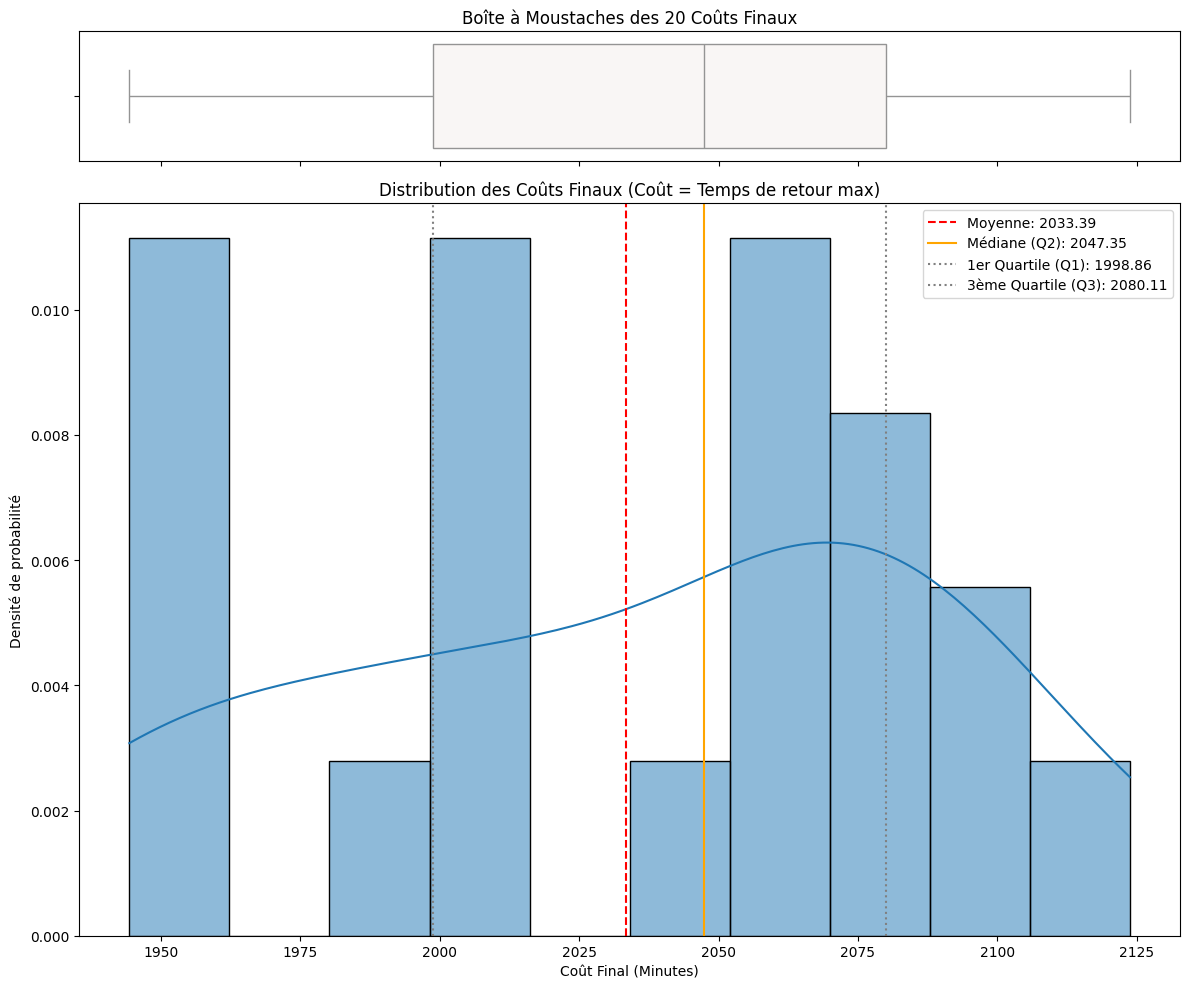


--- Analyse de la Boîte à Moustaches ---
  Min (borne inf.) : 1944.30
  Q1 (25%)         : 1998.86 (25% des coûts sont en dessous)
  Médiane (50%)    : 2047.35 (La moitié des coûts sont en dessous)
  Q3 (75%)         : 2080.11 (75% des coûts sont en dessous)
  Max (borne sup.) : 2123.78


In [2]:
# --- 8. Visualisation de l'Étude Statistique ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filtrer les 'inf' s'il y en a (solutions invalides)
couts_valides = [c for c in tous_les_couts if c != float('inf')]

if not couts_valides:
    print("Aucune solution valide n'a été trouvée pour la visualisation.")
else:
    # --- Création de la figure ---
    fig, (ax_box, ax_hist) = plt.subplots(2, 1, 
                                        figsize=(12, 10), 
                                        sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    # 1. Boîte à moustaches (Box Plot)
    sns.boxplot(x=couts_valides, ax=ax_box, palette="vlag")
    ax_box.set_title("Boîte à Moustaches des 20 Coûts Finaux")
    ax_box.set_xlabel('')
    
    # 2. Histogramme et KDE (Kernel Density Estimate)
    sns.histplot(x=couts_valides, ax=ax_hist, bins=10, kde=True, stat="density")
    ax_hist.set_title("Distribution des Coûts Finaux (Coût = Temps de retour max)")
    ax_hist.set_xlabel("Coût Final (Minutes)")
    ax_hist.set_ylabel("Densité de probabilité")

    # Calcul des quartiles (les "cadrans" que vous avez mentionnés)
    q1 = np.percentile(couts_valides, 25)
    median = np.percentile(couts_valides, 50)
    q3 = np.percentile(couts_valides, 75)
    
    # Ajout des lignes pour les statistiques
    ax_hist.axvline(np.mean(couts_valides), color='red', linestyle='--', label=f'Moyenne: {np.mean(couts_valides):.2f}')
    ax_hist.axvline(median, color='orange', linestyle='-', label=f'Médiane (Q2): {median:.2f}')
    ax_hist.axvline(q1, color='gray', linestyle=':', label=f'1er Quartile (Q1): {q1:.2f}')
    ax_hist.axvline(q3, color='gray', linestyle=':', label=f'3ème Quartile (Q3): {q3:.2f}')
    
    ax_hist.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Analyse de la Boîte à Moustaches ---")
    print(f"  Min (borne inf.) : {np.min(couts_valides):.2f}")
    print(f"  Q1 (25%)         : {q1:.2f} (25% des coûts sont en dessous)")
    print(f"  Médiane (50%)    : {median:.2f} (La moitié des coûts sont en dessous)")
    print(f"  Q3 (75%)         : {q3:.2f} (75% des coûts sont en dessous)")
    print(f"  Max (borne sup.) : {np.max(couts_valides):.2f}")


## 5. Références bibliographiques

- Analyse de la complexité :
https://fr.wikipedia.org/wiki/Analyse_de_la_complexit%C3%A9_des_algorithmes

- Théorie des Graphes :
https://fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes

- Problème du voyageur de commerce : 
https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce

- P, NP et les classes : 
https://www.geeksforgeeks.org/dsa/types-of-complexity-classes-p-np-conp-np-hard-and-np-complete
